# A Convolutional Binarized Network

We will now move on to *convolutional QNNs*, which will include some new types of layers: convolution and pooling. These networks have excellent performance on data that has some [locality](https://en.wikipedia.org/wiki/Locality_of_reference), such as images, video and sound. 

## New Challenge: Recognizing Traffic Signs

The example network we will use in this section will do something slightly more exciting than classifying black-and-white handwritten digits. It will classify 32x32 color images of traffic signs from the [German Traffic Sign Recognition Benchmark](http://benchmark.ini.rub.de/?section=gtsrb&subsection=news). 

The tutorial comes with four example images from the GTSRB test set:

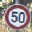

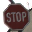

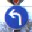

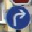

(3, 32, 32)


In [32]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

# define a small utility function to first display, then prepare the
# images for classification
def prepare_gtsrb(img):
    # make sure the image is the size expected by the network
    img = img.resize((32, 32))
    display(img)
    # convert to numpy array
    img = np.asarray(img)
    # we need the data layout to be (channels, rows, columns)
    # but it comes in (rows, columns, channels) format, so we
    # need to transpose the axes:
    img = img.transpose((2, 0, 1))
    # finally, our network is trained with BGR instead of RGB images,
    # so we need to invert the order of channels in the channel axis:
    img = img[::-1, :, :]
    return img

# load test images and prepare them
img_50 = prepare_gtsrb(Image.open("gtsrb_images/50.jpg"))
img_stop = prepare_gtsrb(Image.open("gtsrb_images/stop.jpg"))
img_left = prepare_gtsrb(Image.open("gtsrb_images/left.jpg"))
img_right = prepare_gtsrb(Image.open("gtsrb_images/right.jpg"))

# print the shape of one of the images to make sure it's correct
print(img_50.shape)

Notice how we did some preprocessing inside the prepare_gtsrb function -- resizing the images to be the correct size expected by the network, converting and transposing to a numpy array, then flipping the color axis to be ordered as BGR instead of RGB. Why did we have to do this last part? This is all about assumptions:

1. The layer implementations we have in Python assume that color images have the color (channel) dimension as the first dimension, so this is why we need to transpose.
2. This particular network is trained with the assumption that the order of color channels is blue-green-red, but the loaded images use red-green-blue ordering, so this is why we need to flip the order of elements in the color axis.

But besides this little change in how we loaded the images, loading the network itself will be exactly as before:

In [26]:
from QNN.layers import *
import pickle

# load the QNN
qnn = pickle.load(open("gtsrb-w1a1.pickle", "rb"))
qnn

OK, let's give it a whirl and see if it works! This particular network can recognize 43 different traffic signs, and (just as the previous networks) will indicate its prediction as the largest-valued element of a 43-dimensional vector. But how do we know which class corresponds to which vector index? That information comes from the GTSRB dataset itself.

In [33]:
gtsrb_classes = ['20 Km/h', '30 Km/h', '50 Km/h', '60 Km/h', '70 Km/h', '80 Km/h', 'End 80 Km/h', '100 Km/h', '120 Km/h', 'No overtaking', 'No overtaking for large trucks', 'Priority crossroad', 'Priority road', 'Give way', 'Stop', 'No vehicles', 'Prohibited for vehicles with a permitted gross weight over 3.5t including their trailers, and for tractors except passenger cars and buses', 'No entry for vehicular traffic', 'Danger Ahead', 'Bend to left', 'Bend to right', 'Double bend (first to left)', 'Uneven road', 'Road slippery when wet or dirty', 'Road narrows (right)', 'Road works', 'Traffic signals', 'Pedestrians in road ahead', 'Children crossing ahead', 'Bicycles prohibited', 'Risk of snow or ice', 'Wild animals', 'End of all speed and overtaking restrictions', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Ahead or right only', 'Ahead or left only', 'Pass by on right', 'Pass by on left', 'Roundabout', 'End of no-overtaking zone', 'End of no-overtaking zone for vehicles with a permitted gross weight over 3.5t including their trailers, and for tractors except passenger cars and buses']

def gtsrb_predict(img):
    # get the predictions array
    res = predict(qnn, img)
    # return the index of the largest prediction, then use the
    # classes array to map to a human-readable string
    winner_ind = np.argmax(res)
    winner_class = gtsrb_classes[winner_ind]
    # the sum of the output values add up to 1 due to softmax,
    # so we can interpret them as probabilities
    winner_prob = 100 * res[winner_ind]
    print("The QNN predicts this is a %s sign with %f percent probability" % (winner_class, winner_prob))

gtsrb_predict(img_50)
gtsrb_predict(img_stop)
gtsrb_predict(img_left)
gtsrb_predict(img_right)

The QNN predicts this is a 50 Km/h sign with 96.196610 percent probability
The QNN predicts this is a Stop sign with 99.978381 percent probability
The QNN predicts this is a Turn left ahead sign with 99.998236 percent probability
The QNN predicts this is a Turn right ahead sign with 99.953973 percent probability
